### PCA in Machine Learning Workflows
#### Machine Learning I - Maestría en Analítica Aplicada
#### Universidad de la Sabana
#### Prof: Hugo Franco
#### Example: Principal Component Analysis

<img src="culmen_depth.png" width="50%">

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer

# Load the penguins dataset
penguins = sns.load_dataset('penguins')

# Display initial information
print("Dataset Overview:")
print(penguins.info())
print("\nClass Distribution:")
print(penguins['species'].value_counts())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None

Class Distribution:
species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64


#### Imputation strategies implemented in SimpleImputer 
* mean (default for numeric data)
* median (usually more robust than mean)
* most_frequent
* constant (requires the filling value)

In [2]:
# Define feature groups
numeric_features = ['bill_length_mm', 'bill_depth_mm', 
                   'flipper_length_mm', 'body_mass_g']
categorical_features = ['sex', 'island']

# Create the numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the categorical transformer with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        drop='first',  # Drop first category to avoid multicollinearity
        sparse_output=False,  # Return dense array instead of sparse matrix
        handle_unknown='ignore'  # Handle new categories in test data
    ))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Print encoded feature names
def get_feature_names(preprocessor):
    # Get feature names from numeric features
    numeric_features_out = numeric_features

    # Get feature names from categorical features after encoding
    cat_features = (preprocessor
                   .named_transformers_['cat']
                   .named_steps['onehot']
                   .get_feature_names_out(categorical_features))
    
    # Combine both feature sets
    return numeric_features_out + list(cat_features)

In [3]:
# Create full pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ))
])

# Prepare data
X = penguins.drop(['species'], axis=1)
y = penguins['species']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


Model Performance:
Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



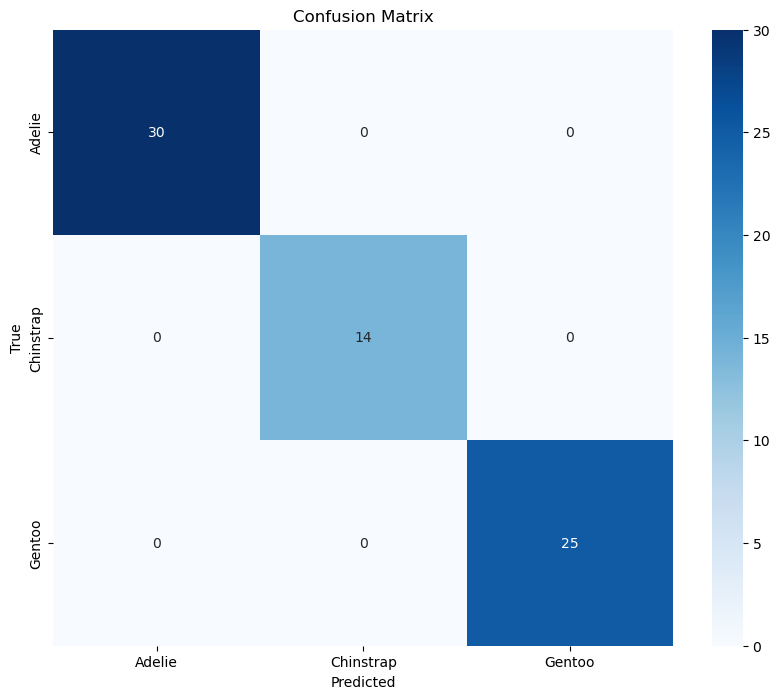


Encoded Feature Names:
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_Male', 'sex_missing', 'island_Dream', 'island_Torgersen']


In [4]:
# Train model
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)

# Print performance metrics
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=penguins['species'].unique(),
            yticklabels=penguins['species'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Get feature names after encoding
feature_names = get_feature_names(preprocessor)
print("\nEncoded Feature Names:")
print(feature_names)

A (risky) method to deal with potential outliers: quartile capping.


Results with Outlier Capping:
Accuracy: 0.9855072463768116

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98        32
   Chinstrap       1.00      0.94      0.97        16
      Gentoo       1.00      1.00      1.00        21

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



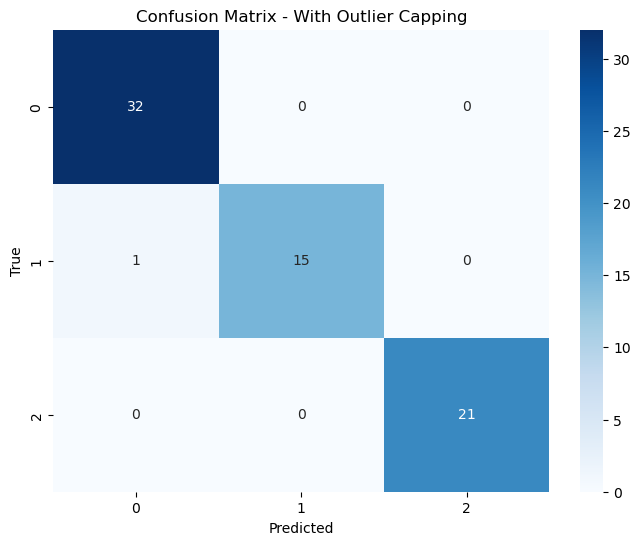

In [5]:
def cap_outliers(df, columns, lower_percentile=1, upper_percentile=99):
    df_capped = df.copy()
    for column in columns:
        lower = np.percentile(df[column].dropna(), lower_percentile)
        upper = np.percentile(df[column].dropna(), upper_percentile)
        df_capped[column] = df_capped[column].clip(lower=lower, upper=upper)
    return df_capped

# Get numerical columns from features only (excluding target)
numerical_cols_features = X.select_dtypes(include=['float64', 'int64']).columns

# Apply outlier capping
X_capped = cap_outliers(X, numerical_cols_features)

# Create pipeline with outlier capping and proper preprocessing
capped_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('imputer', KNNImputer(n_neighbors=5))
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore'
            ))
        ]), categorical_features)
    ])),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluate with outlier capping
X_train_capped, X_test_capped, y_train, y_test = train_test_split(
    X_capped, y, test_size=0.2, random_state=42)

capped_pipe.fit(X_train_capped, y_train)
y_pred_capped = capped_pipe.predict(X_test_capped)

# Evaluate results with visualization
print("\nResults with Outlier Capping:")
print("Accuracy:", accuracy_score(y_test, y_pred_capped))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_capped, zero_division=0))

# Visualize confusion matrix for capped results
plt.figure(figsize=(8, 6))
cm_capped = confusion_matrix(y_test, y_pred_capped)
sns.heatmap(cm_capped, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - With Outlier Capping')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Challenge (Workshop)
1. Use the following code stub to perform the same task on the Cleveland Heart Disease dataset. Test the impact of each imputation strategy in the model performance. 
2. Compare the performance of Random Forests vs. XGBoost


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
           'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, names=columns, na_values='?')



print("Dataset Overview:")
print(df.info())




Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB
None


In [7]:
# Define feature groups
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Create the numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the categorical transformer with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(
        drop='first',  # Drop first category to avoid multicollinearity
        sparse_output=False,  # Return dense array instead of sparse matrix
        handle_unknown='ignore'  # Handle new categories in test data
    ))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Print encoded feature names
def get_feature_names(preprocessor):
    # Get feature names from numeric features
    numeric_features_out = numeric_features

    # Get feature names from categorical features after encoding
    cat_features = (preprocessor
                   .named_transformers_['cat']
                   .named_steps['onehot']
                   .get_feature_names_out(categorical_features))
    
    # Combine both feature sets
    return numeric_features_out + list(cat_features)


In [8]:
# Create full pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    ))
])

# Prepare data
X = df.drop(['target'], axis=1)
y = (df['target'] > 0).astype(int)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


Model Performance:
Accuracy: 0.9180327868852459

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92        33
           1       0.90      0.93      0.91        28

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



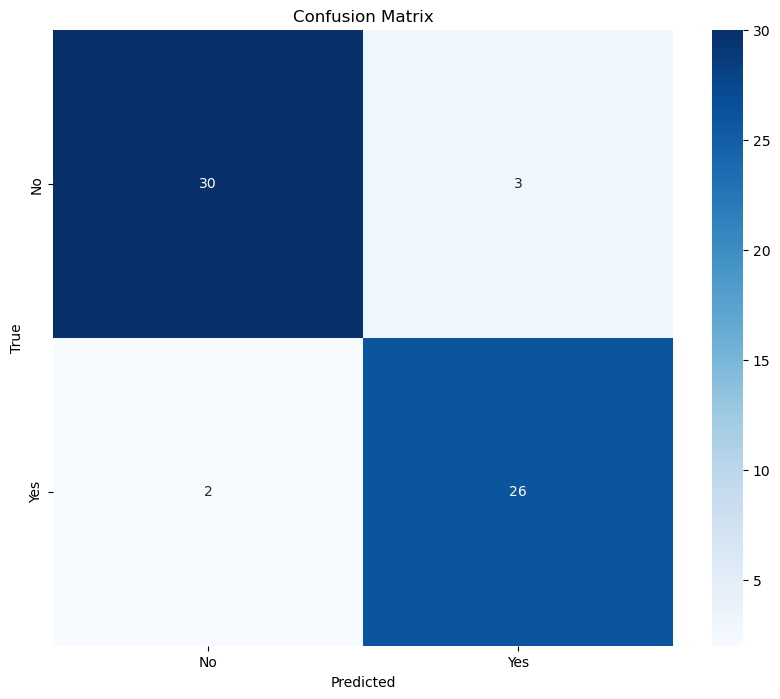


Encoded Feature Names:
['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'sex_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'fbs_1.0', 'restecg_1.0', 'restecg_2.0', 'exang_1.0', 'slope_2.0', 'slope_3.0', 'thal_6.0', 'thal_7.0']


In [9]:
# Train model
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)

# Print performance metrics
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Get feature names after encoding
feature_names = get_feature_names(preprocessor)
print("\nEncoded Feature Names:")
print(feature_names)



Results with Outlier Capping:
Accuracy: 0.8688524590163934

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



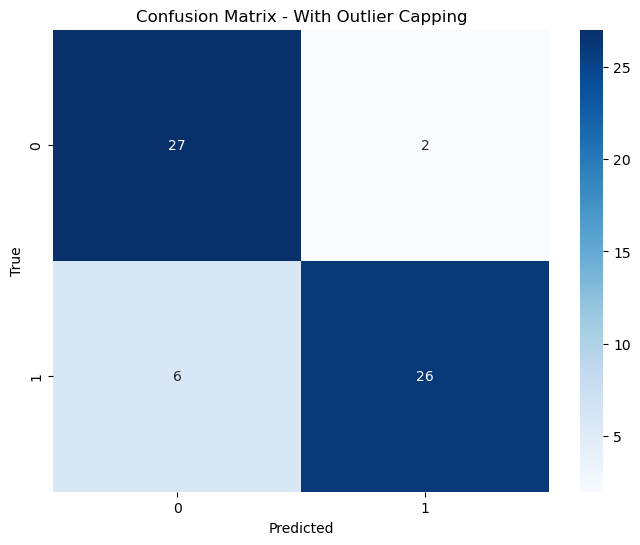

In [10]:
def cap_outliers(df, columns, lower_percentile=1, upper_percentile=99):
    df_capped = df.copy()
    for column in columns:
        lower = np.percentile(df[column].dropna(), lower_percentile)
        upper = np.percentile(df[column].dropna(), upper_percentile)
        df_capped[column] = df_capped[column].clip(lower=lower, upper=upper)
    return df_capped

# Get numerical columns from features only (excluding target)
numerical_cols_features = X.select_dtypes(include=['float64', 'int64']).columns

# Apply outlier capping
X_capped = cap_outliers(X, numerical_cols_features)

# Create pipeline with outlier capping and proper preprocessing
capped_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('imputer', KNNImputer(n_neighbors=5))
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore'
            ))
        ]), categorical_features)
    ])),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Evaluate with outlier capping
X_train_capped, X_test_capped, y_train, y_test = train_test_split(
    X_capped, y, test_size=0.2, random_state=42)

capped_pipe.fit(X_train_capped, y_train)
y_pred_capped = capped_pipe.predict(X_test_capped)

# Evaluate results with visualization
print("\nResults with Outlier Capping:")
print("Accuracy:", accuracy_score(y_test, y_pred_capped))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_capped, zero_division=0))

# Visualize confusion matrix for capped results
plt.figure(figsize=(8, 6))
cm_capped = confusion_matrix(y_test, y_pred_capped)
sns.heatmap(cm_capped, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - With Outlier Capping')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### XGBoost

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from xgboost import plot_importance  # For feature importance visualization
import matplotlib.pyplot as plt

In [40]:
X = df.drop("target", axis=1)
y = (df['target'] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [41]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=100,
    random_state=42
)


In [42]:
model.fit(X_train, y_train)

# Predict class labels
y_pred = model.predict(X_test)

# Predict class probabilities
y_prob = model.predict_proba(X_test)


print("\n Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n",
      classification_report(y_test, y_pred, target_names=['No', 'Yes']))

print("\n Predicted class labels:", y_pred[:5])
print(" Actual class labels   :", y_test[:5])

print("\n Predicted probabilities for first 5 samples:\n", y_prob[:5])



 Accuracy: 0.8852459016393442

 Classification Report:
               precision    recall  f1-score   support

          No       0.96      0.82      0.89        33
         Yes       0.82      0.96      0.89        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.89      0.89        61


 Predicted class labels: [1 1 0 0 0]
 Actual class labels   : 219    0
271    0
89     0
101    0
67     0
Name: target, dtype: int64

 Predicted probabilities for first 5 samples:
 [[0.3339169  0.6660831 ]
 [0.46729326 0.53270674]
 [0.99204475 0.00795524]
 [0.98392665 0.01607334]
 [0.5292566  0.47074345]]


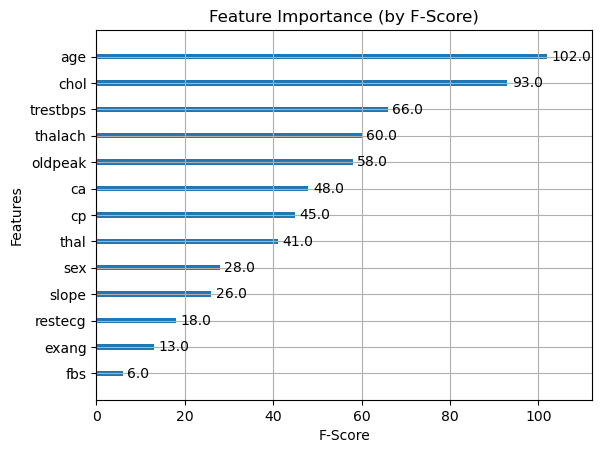

In [43]:
plot_importance(model, importance_type='weight', xlabel='F-Score')
plt.title("Feature Importance (by F-Score)")
plt.show()

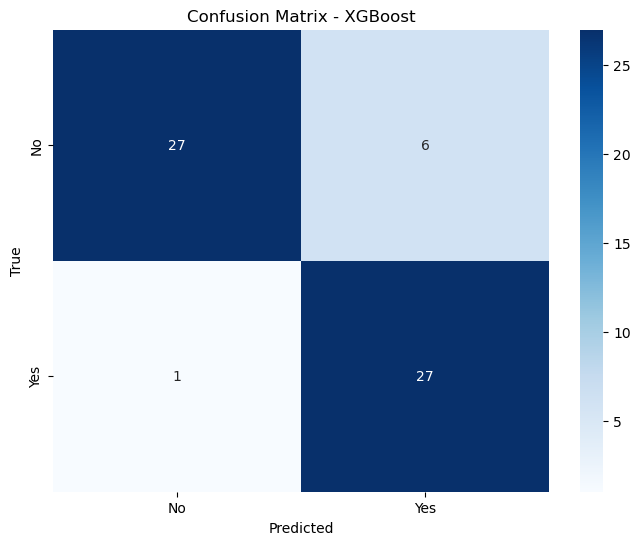

In [44]:
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()